In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import auc, roc_curve ,roc_auc_score

In [176]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [177]:
print(train.shape)
print(test.shape)

(58645, 13)
(39098, 12)


In [178]:
train.head(3)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0


In [179]:
test.head(3)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2


In [180]:
print(train['loan_status'].unique())
print(train['loan_status'].value_counts()/len(train)*100)

[0 1]
loan_status
0    85.761787
1    14.238213
Name: count, dtype: float64


In [181]:
df = pd.concat([train , test])
print(df.shape)

(97743, 13)


## Data preprocessing

### 1. Null values

In [182]:
df.isnull().sum()

,0
id,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0


### 2. Remove id

In [183]:
df = df.drop(columns=['id'])
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0


In [184]:
print(df.columns)
print(df.shape)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')
(97743, 12)


### 3. Outliers

In [185]:
def find_outliers(df , col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound))
    outlier_counts = outliers.sum()

    return outlier_counts


In [186]:
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0


In [187]:
col = ['person_age', 'person_income',
       'person_emp_length',  'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length']

for i in col:
    print(i ,'-->' , find_outliers(df ,i))

person_age --> 4066
person_income --> 3953
person_emp_length --> 2052
loan_amnt --> 3433
loan_int_rate --> 45
loan_percent_income --> 2021
cb_person_cred_hist_length --> 3429


In [188]:
def cap_outliers(df, col):
    capped_df = df.copy()

    Q1 = capped_df[col].quantile(0.25)
    Q3 = capped_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    capped_df[col] = capped_df[col].clip(lower=lower_bound, upper=upper_bound)

    return capped_df

In [189]:
col = ['person_age', 'person_income',
       'person_emp_length',  'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length']

for i in col:
    df = cap_outliers(df , i)

In [190]:
col = ['person_age', 'person_income',
       'person_emp_length',  'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length']

for i in col:
    print(i ,'-->' , find_outliers(df ,i))

person_age --> 0
person_income --> 0
person_emp_length --> 0
loan_amnt --> 0
loan_int_rate --> 0
loan_percent_income --> 0
cb_person_cred_hist_length --> 0


In [191]:
df.shape

(97743, 12)

In [192]:
print(train.shape)
print(test.shape)

(58645, 13)
(39098, 12)


## Seprating my train and test data file

In [193]:
train = df.head(58645)
test = df.tail(39098)

In [194]:
print(train.shape)
print(test.shape)

(58645, 12)
(39098, 12)


In [195]:
test = test.drop(columns=['loan_status'])

In [196]:
test.shape

(39098, 11)

In [ ]:
##########################################################################################

### 4. Encoding for catgorical columns

In [197]:
train['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [198]:
train['loan_intent'].unique()

array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
       'HOMEIMPROVEMENT'], dtype=object)

In [199]:
train['loan_grade'].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [200]:
train['cb_person_default_on_file'].unique()

array(['N', 'Y'], dtype=object)

In [201]:
# oridnal encoding train
train_encoder = OrdinalEncoder(categories=[['A','B','C','D','E','F','G']])
train['loan_grade'] = train_encoder.fit_transform(train[['loan_grade']])

train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37.0,35000,RENT,0.0,EDUCATION,1.0,6000,11.49,0.17,N,14.0,0.0
1,22.0,56000,OWN,6.0,MEDICAL,2.0,4000,13.35,0.07,N,2.0,0.0
2,29.0,28800,OWN,8.0,PERSONAL,0.0,6000,8.90,0.21,N,10.0,0.0
3,30.0,70000,RENT,14.0,VENTURE,1.0,12000,11.11,0.17,N,5.0,0.0
4,22.0,60000,RENT,2.0,MEDICAL,0.0,6000,6.92,0.10,N,3.0,0.0


In [202]:
# ordinal encoding test
test_encoder = OrdinalEncoder(categories=[['A','B','C','D','E','F','G']])
test['loan_grade'] = test_encoder.fit_transform(test[['loan_grade']])

test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23.0,69000,RENT,3.0,HOMEIMPROVEMENT,5.0,22500,15.76,0.36,N,2.0
1,26.0,96000,MORTGAGE,6.0,PERSONAL,2.0,10000,12.68,0.10,Y,4.0
2,26.0,30000,RENT,5.0,VENTURE,4.0,4000,17.19,0.13,Y,2.0
3,33.0,50000,RENT,4.0,DEBTCONSOLIDATION,0.0,7000,8.90,0.14,N,7.0
4,26.0,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,3.0,15000,16.32,0.15,Y,4.0


In [203]:
# ohe train
train = pd.get_dummies(train, columns=['person_home_ownership','loan_intent','cb_person_default_on_file'],drop_first=True)

train.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,37.0,35000,0.0,1.0,6000,11.49,0.17,14.0,0.0,False,False,True,True,False,False,False,False,False
1,22.0,56000,6.0,2.0,4000,13.35,0.07,2.0,0.0,False,True,False,False,False,True,False,False,False
2,29.0,28800,8.0,0.0,6000,8.90,0.21,10.0,0.0,False,True,False,False,False,False,True,False,False
3,30.0,70000,14.0,1.0,12000,11.11,0.17,5.0,0.0,False,False,True,False,False,False,False,True,False
4,22.0,60000,2.0,0.0,6000,6.92,0.10,3.0,0.0,False,False,True,False,False,True,False,False,False


In [204]:
# ohe test
test = pd.get_dummies(test, columns=['person_home_ownership','loan_intent','cb_person_default_on_file'],drop_first=True)

test.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,23.0,69000,3.0,5.0,22500,15.76,0.36,2.0,False,False,True,False,True,False,False,False,False
1,26.0,96000,6.0,2.0,10000,12.68,0.10,4.0,False,False,False,False,False,False,True,False,True
2,26.0,30000,5.0,4.0,4000,17.19,0.13,2.0,False,False,True,False,False,False,False,True,True
3,33.0,50000,4.0,0.0,7000,8.90,0.14,7.0,False,False,True,False,False,False,False,False,False
4,26.0,102000,8.0,3.0,15000,16.32,0.15,4.0,False,False,False,False,True,False,False,False,True


In [205]:
print(train.shape)
print(test.shape)

(58645, 18)
(39098, 17)


## 5. Scaling

In [206]:
# train
scaler_train = StandardScaler()

columns_to_scale = train.columns.difference(['loan_status'])

train[columns_to_scale] = scaler_train.fit_transform(train[columns_to_scale])
train.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,1.868512,-1.019384,-1.257755,-0.063697,-0.595246,0.267872,0.131337,2.236094,0.0,-0.038986,-0.237768,0.957538,1.944005,-0.346305,-0.478719,-0.453837,-0.4537,-0.417419
1,-1.022329,-0.233272,0.370830,0.892168,-0.979171,0.881073,-0.992837,-1.004576,0.0,-0.038986,4.205788,-1.044345,-0.514402,-0.346305,2.088910,-0.453837,-0.4537,-0.417419
2,0.326730,-1.251474,0.913692,-1.019563,-0.595246,-0.585992,0.581006,1.155871,0.0,-0.038986,4.205788,-1.044345,-0.514402,-0.346305,-0.478719,2.203436,-0.4537,-0.417419
3,0.519453,0.290802,2.542277,-0.063697,0.556528,0.142595,0.131337,-0.194408,0.0,-0.038986,-0.237768,0.957538,-0.514402,-0.346305,-0.478719,-0.453837,2.2041,-0.417419
4,-1.022329,-0.083537,-0.714894,-1.019563,-0.595246,-1.238754,-0.655585,-0.734520,0.0,-0.038986,-0.237768,0.957538,-0.514402,-0.346305,2.088910,-0.453837,-0.4537,-0.417419


<Axes: >

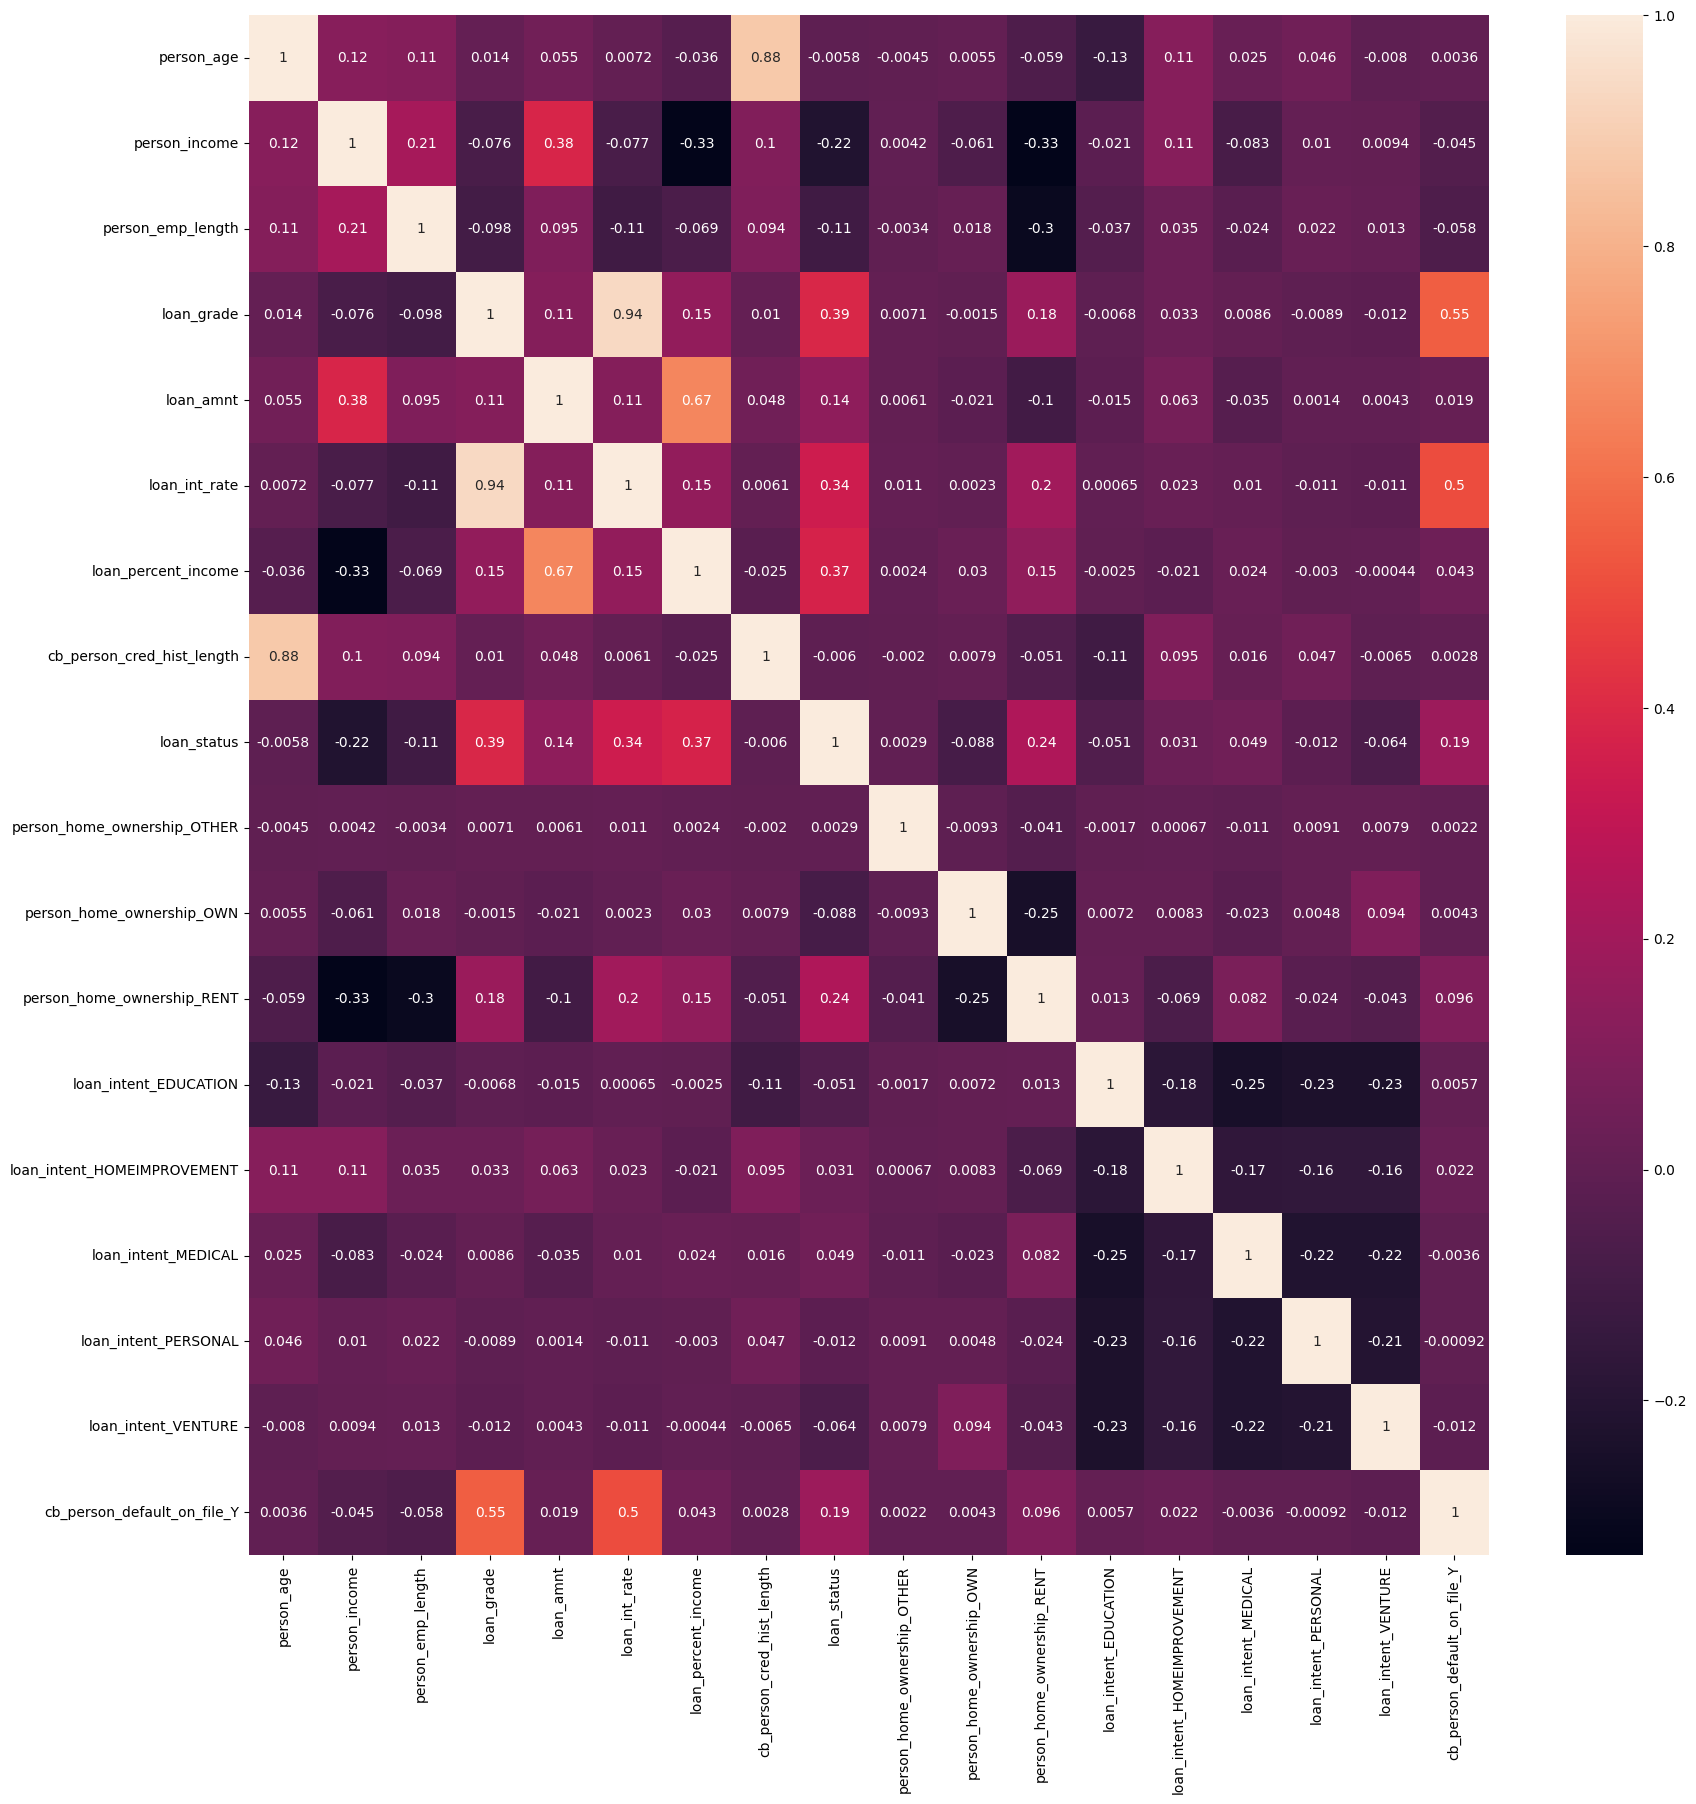

In [207]:
fig = plt.figure(figsize=(20, 20))

sns.heatmap(train.corr(),annot=True)

In [208]:
# test
scaler_train = StandardScaler()

columns_to_scale = test.columns

test[columns_to_scale] = scaler_train.fit_transform(test[columns_to_scale])
test.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,-0.833685,0.253469,-0.444003,3.788284,2.568532,1.688712,2.269226,-1.002273,-0.044996,-0.235594,0.963280,-0.510227,2.877555,-0.485062,-0.459458,-0.451968,-0.420349
1,-0.254273,1.268717,0.375157,0.902528,0.167165,0.668661,-0.660413,-0.464826,-0.044996,-0.235594,-1.038119,-0.510227,-0.347517,-0.485062,2.176477,-0.451968,2.378973
2,-0.254273,-1.213000,0.102103,2.826366,-0.985491,2.162307,-0.322378,-1.002273,-0.044996,-0.235594,0.963280,-0.510227,-0.347517,-0.485062,-0.459458,2.212545,2.378973
3,1.097689,-0.460965,-0.170950,-1.021310,-0.409163,-0.583220,-0.209699,0.341344,-0.044996,-0.235594,0.963280,-0.510227,-0.347517,-0.485062,-0.459458,-0.451968,-0.420349
4,-0.254273,1.494327,0.921263,1.864447,1.127712,1.874176,-0.097021,-0.464826,-0.044996,-0.235594,-1.038119,-0.510227,2.877555,-0.485062,-0.459458,-0.451968,2.378973


<Axes: >

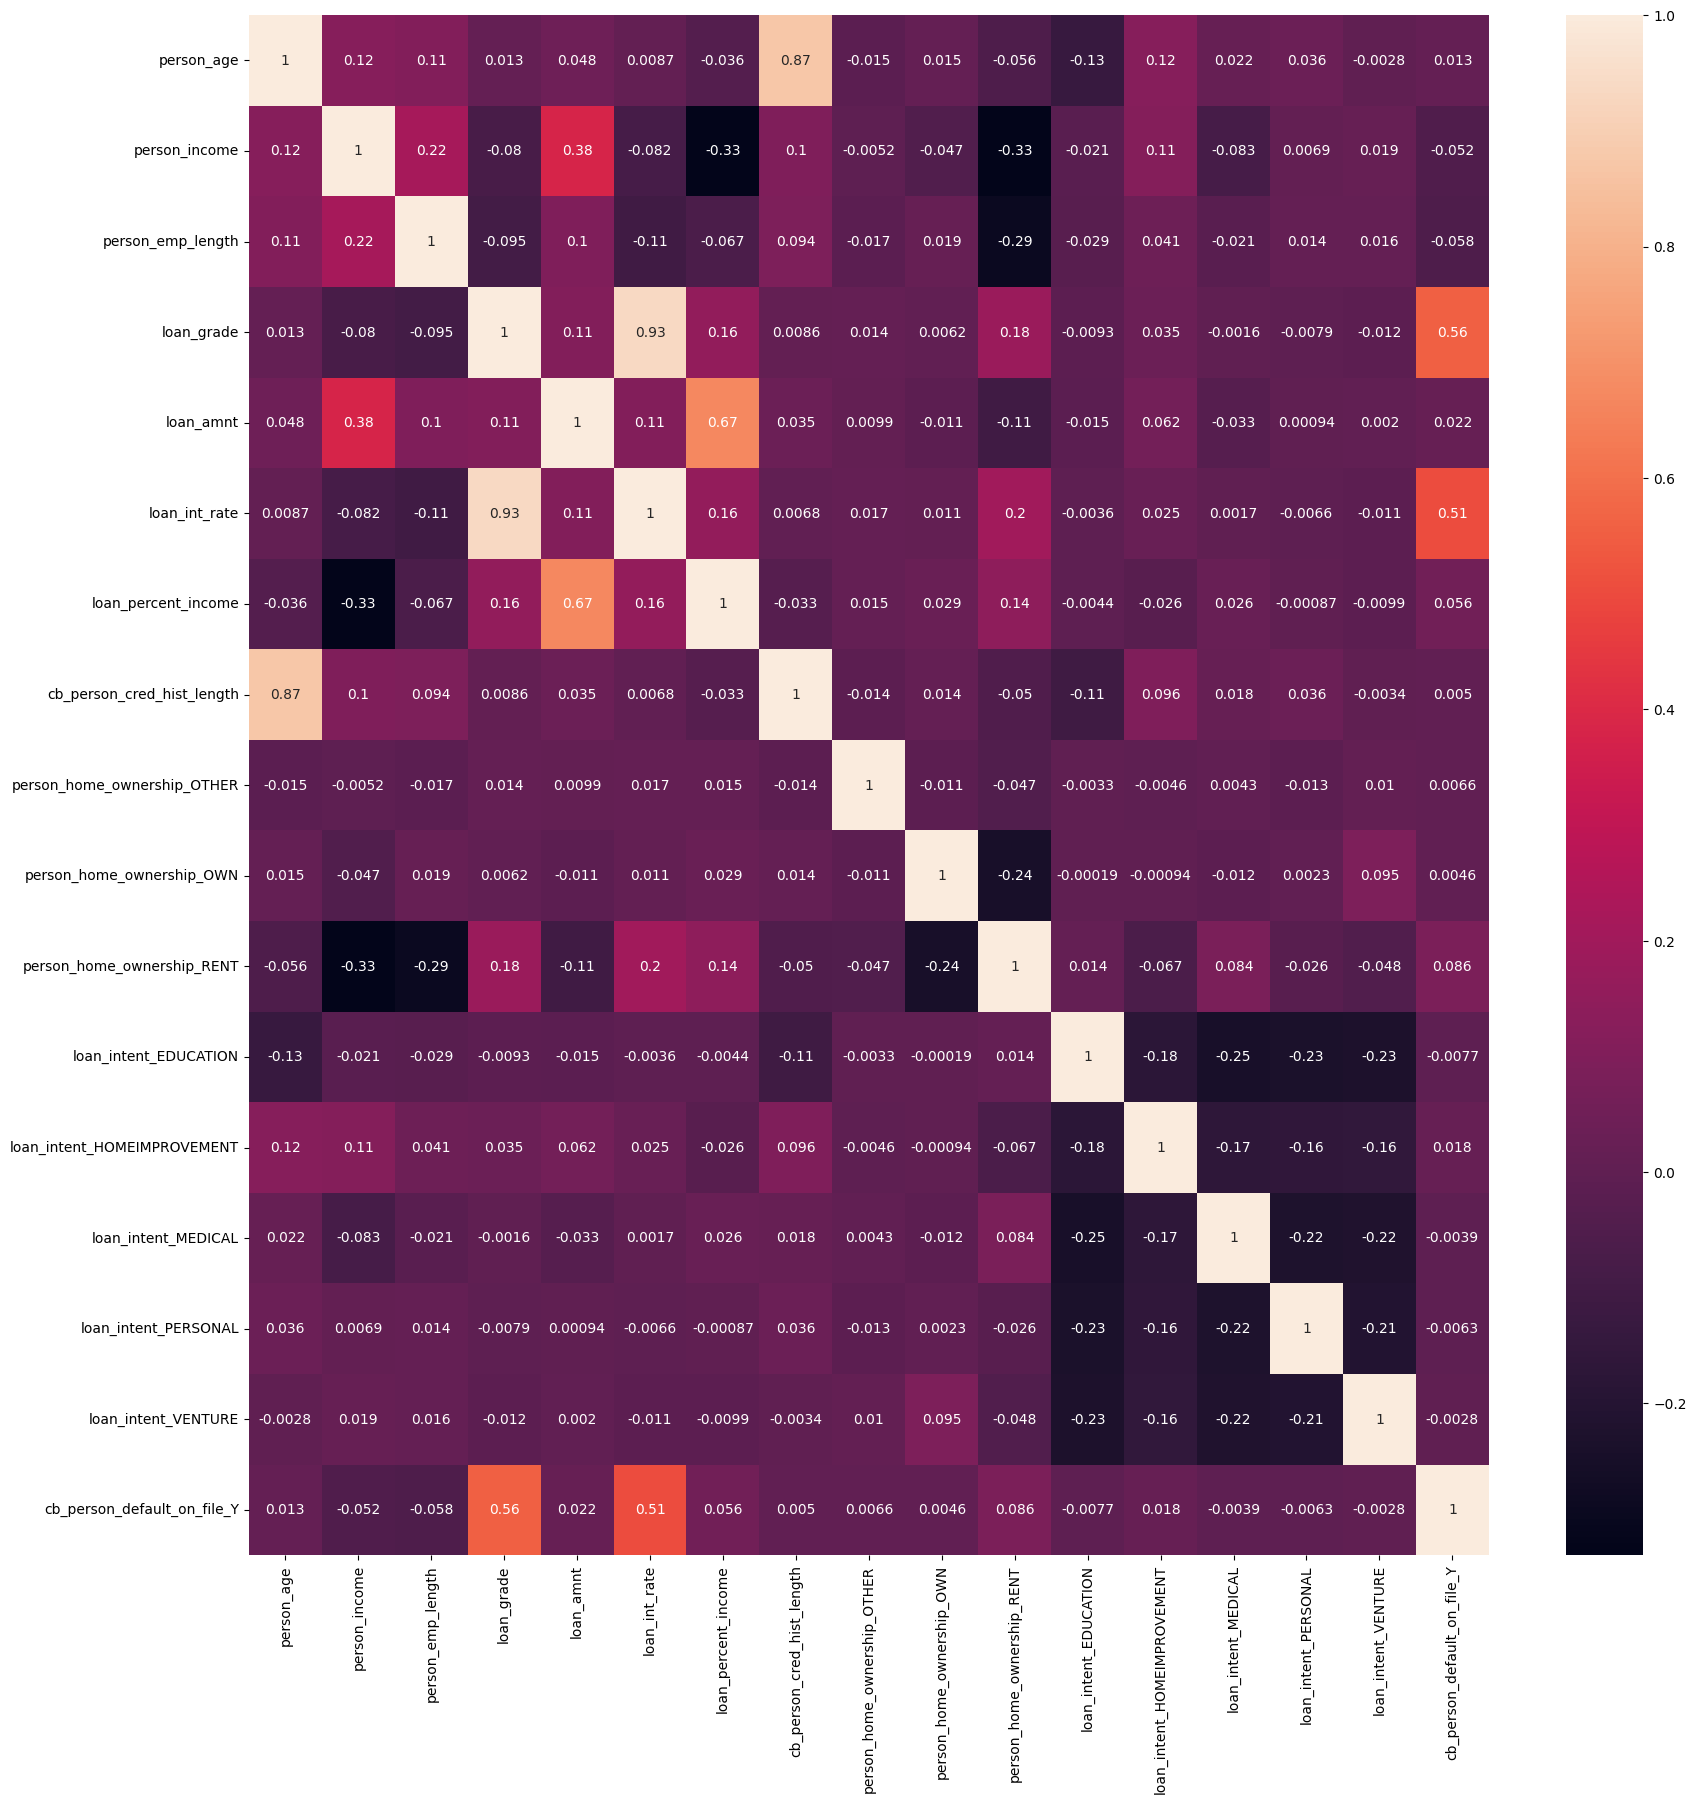

In [209]:
fig = plt.figure(figsize=(20, 20))

sns.heatmap(test.corr(),annot=True)

## Splitting train data

In [210]:
from sklearn.model_selection import train_test_split

In [212]:
train.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,1.868512,-1.019384,-1.257755,-0.063697,-0.595246,0.267872,0.131337,2.236094,0.0,-0.038986,-0.237768,0.957538,1.944005,-0.346305,-0.478719,-0.453837,-0.4537,-0.417419
1,-1.022329,-0.233272,0.370830,0.892168,-0.979171,0.881073,-0.992837,-1.004576,0.0,-0.038986,4.205788,-1.044345,-0.514402,-0.346305,2.088910,-0.453837,-0.4537,-0.417419
2,0.326730,-1.251474,0.913692,-1.019563,-0.595246,-0.585992,0.581006,1.155871,0.0,-0.038986,4.205788,-1.044345,-0.514402,-0.346305,-0.478719,2.203436,-0.4537,-0.417419
3,0.519453,0.290802,2.542277,-0.063697,0.556528,0.142595,0.131337,-0.194408,0.0,-0.038986,-0.237768,0.957538,-0.514402,-0.346305,-0.478719,-0.453837,2.2041,-0.417419
4,-1.022329,-0.083537,-0.714894,-1.019563,-0.595246,-1.238754,-0.655585,-0.734520,0.0,-0.038986,-0.237768,0.957538,-0.514402,-0.346305,2.088910,-0.453837,-0.4537,-0.417419


In [215]:
y = train['loan_status']
x = train.drop(columns=['loan_status'])

In [223]:
y.value_counts()/len(y)*100

,count
loan_status,
0.0,85.761787
1.0,14.238213


In [224]:
from imblearn.over_sampling import SMOTE

In [227]:
smote = SMOTE(random_state=42)

# Perform oversampling on the training data
X_resampled, y_resampled = smote.fit_resample(x, y)

In [228]:
y_resampled.value_counts()/len(y_resampled)*100

,count
loan_status,
0.0,50.0
1.0,50.0


In [230]:
x_train , x_test , y_train , y_test = train_test_split(X_resampled , y_resampled , test_size=0.2 , random_state=42)

In [231]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(80472, 17)
(20118, 17)
(80472,)
(20118,)


In [233]:
x_train.head(3)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
85400,2.405559,-0.554685,-1.141927,1.848034,-1.432184,1.390446,-1.434994,2.448529,-0.038986,-0.237768,0.957538,-0.514402,-0.346305,-0.478719,2.203436,-0.4537,-0.417419
75689,-0.532981,-0.648044,1.060028,-0.063697,1.936989,0.220341,2.483304,-0.610059,-0.038986,-0.237768,0.957538,1.944005,-0.346305,-0.478719,-0.453837,-0.4537,-0.417419
16831,-1.022329,-0.457876,-1.257755,0.892168,-0.364891,0.838215,-0.205916,-0.464464,-0.038986,-0.237768,0.957538,-0.514402,-0.346305,2.088910,-0.453837,-0.4537,2.395674


## Model

In [232]:
!pip install catboost


In [234]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline

In [239]:
# models = [
#     ('Logistic Regression', LogisticRegression()),
#     ('Random Forest', RandomForestClassifier()),
#     ('Support Vector Machine', SVC()),
#     ('Decision Tree', DecisionTreeClassifier()),
#     ('Naive Bayes', GaussianNB()),
#     ('K-Nearest Neighbors', KNeighborsClassifier()),
#     ('Gradient Boosting', GradientBoostingClassifier()),
#     ('XGBoost', XGBClassifier()),
#     ('LightGBM', LGBMClassifier()),
#     ('CatBoost', CatBoostClassifier()),
#     ('Neural Network', MLPClassifier()),
#     ('AdaBoost', AdaBoostClassifier()),
#     ('Bagging Classifier', BaggingClassifier()),
#     ('Extra Trees Classifier', ExtraTreesClassifier()),
#     ('Voting Classifier', VotingClassifier()),
#     ('Stacking Classifier', StackingClassifier())
# ]


models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Support Vector Machine', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('CatBoost', CatBoostClassifier())
]


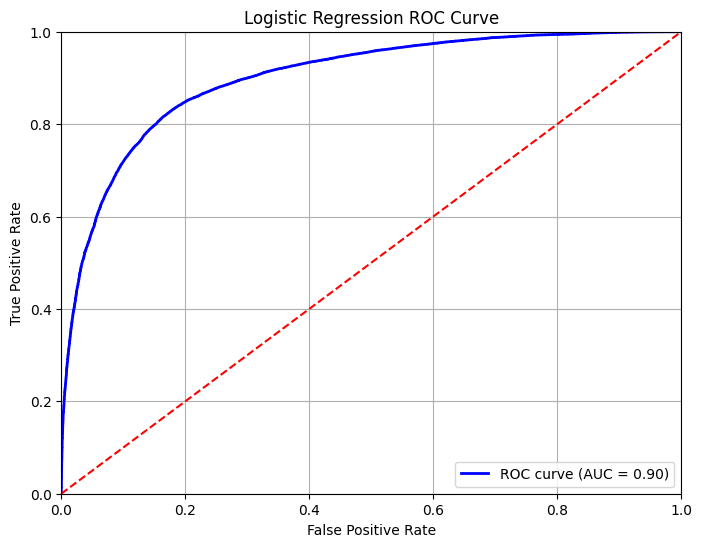

Logistic Regression AUC: 0.90


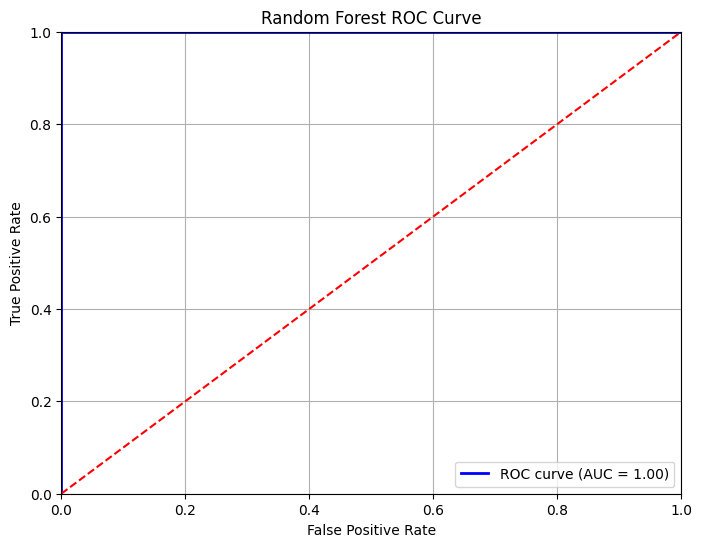

Random Forest AUC: 1.00
Support Vector Machine does not support predict_proba. Skipping ROC curve plotting.
0.8766030420518939


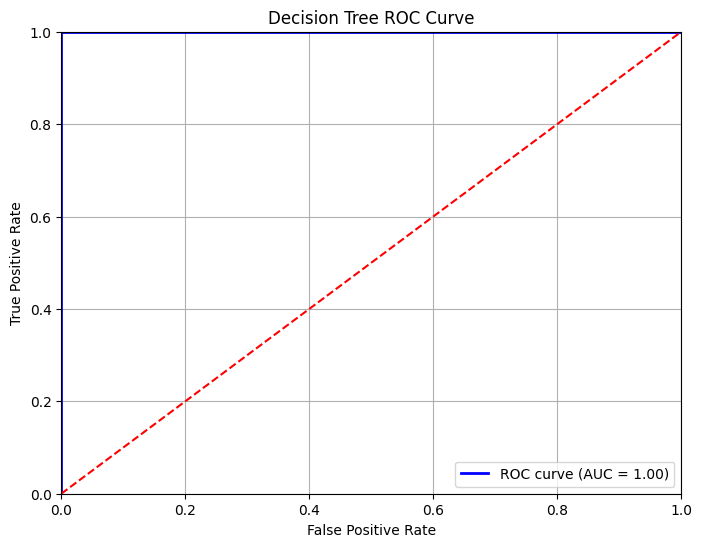

Decision Tree AUC: 1.00


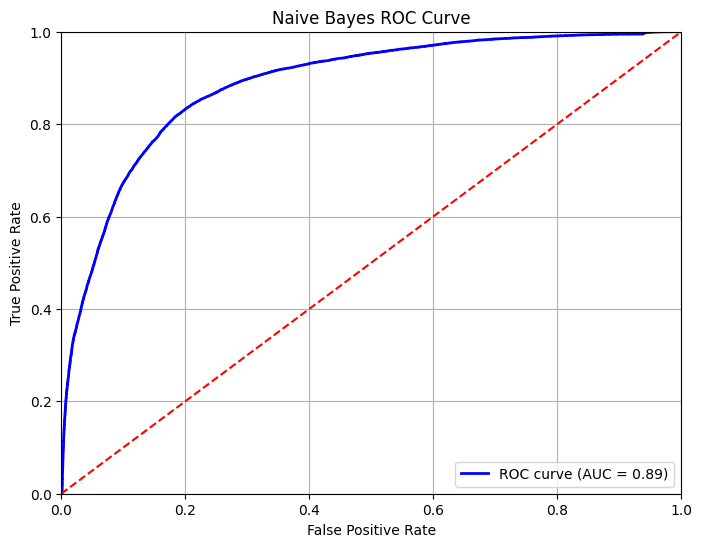

Naive Bayes AUC: 0.89


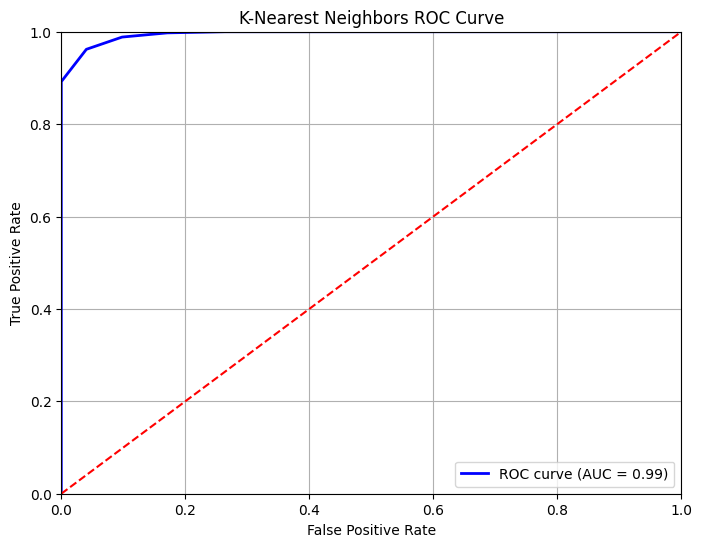

K-Nearest Neighbors AUC: 0.99


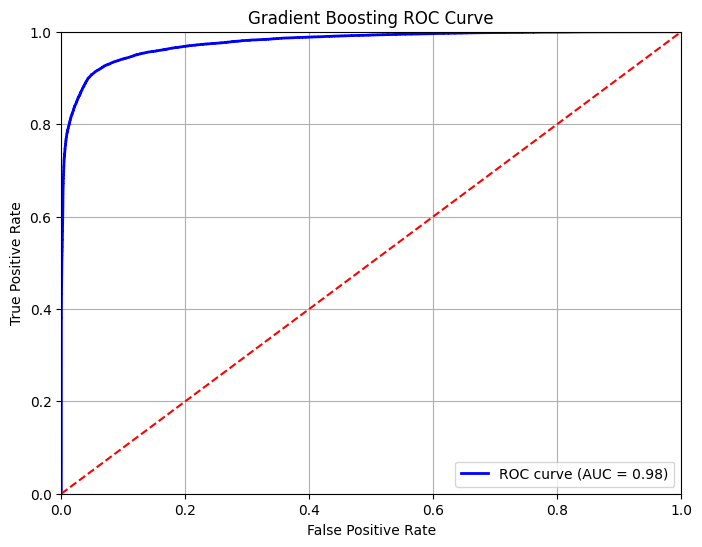

Gradient Boosting AUC: 0.98


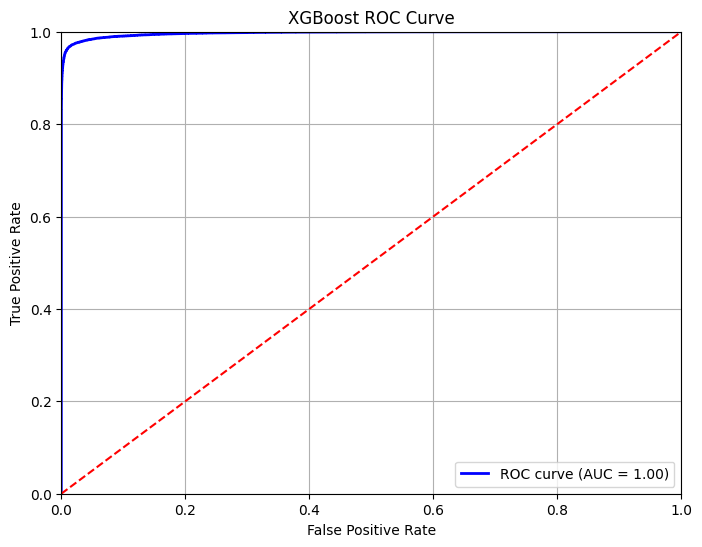

XGBoost AUC: 1.00
[LightGBM] [Info] Number of positive: 40253, number of negative: 40219
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2407
[LightGBM] [Info] Number of data points in the train set: 80472, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500211 -> initscore=0.000845
[LightGBM] [Info] Start training from score 0.000845


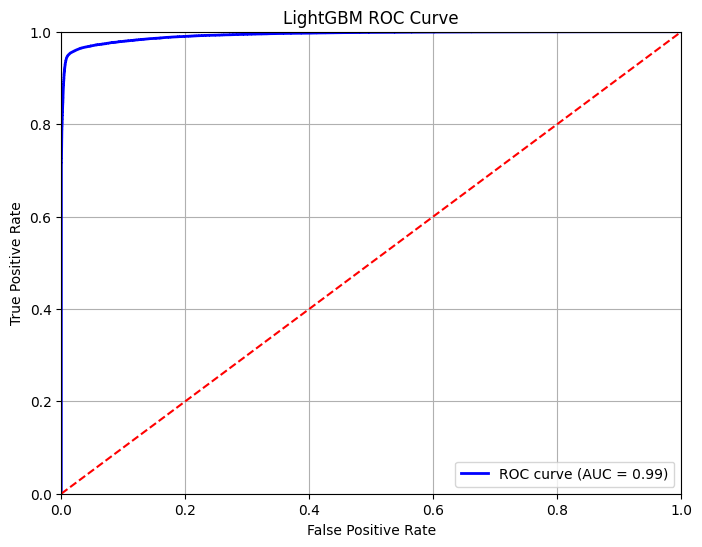

LightGBM AUC: 0.99
Learning rate set to 0.067088
0:	learn: 0.6277616	total: 91.3ms	remaining: 1m 31s
1:	learn: 0.5734657	total: 118ms	remaining: 58.7s
2:	learn: 0.5286945	total: 141ms	remaining: 47s
3:	learn: 0.4980711	total: 180ms	remaining: 44.8s
4:	learn: 0.4678115	total: 207ms	remaining: 41.1s
5:	learn: 0.4411818	total: 231ms	remaining: 38.3s
6:	learn: 0.4236841	total: 255ms	remaining: 36.2s
7:	learn: 0.4072204	total: 280ms	remaining: 34.7s
8:	learn: 0.3931516	total: 309ms	remaining: 34s
9:	learn: 0.3817900	total: 332ms	remaining: 32.9s
10:	learn: 0.3658263	total: 354ms	remaining: 31.8s
11:	learn: 0.3579121	total: 377ms	remaining: 31s
12:	learn: 0.3497996	total: 399ms	remaining: 30.3s
13:	learn: 0.3392075	total: 421ms	remaining: 29.7s
14:	learn: 0.3336344	total: 444ms	remaining: 29.1s
15:	learn: 0.3275331	total: 471ms	remaining: 29s
16:	learn: 0.3226213	total: 495ms	remaining: 28.6s
17:	learn: 0.3167049	total: 526ms	remaining: 28.7s
18:	learn: 0.3093262	total: 550ms	remaining: 28.4

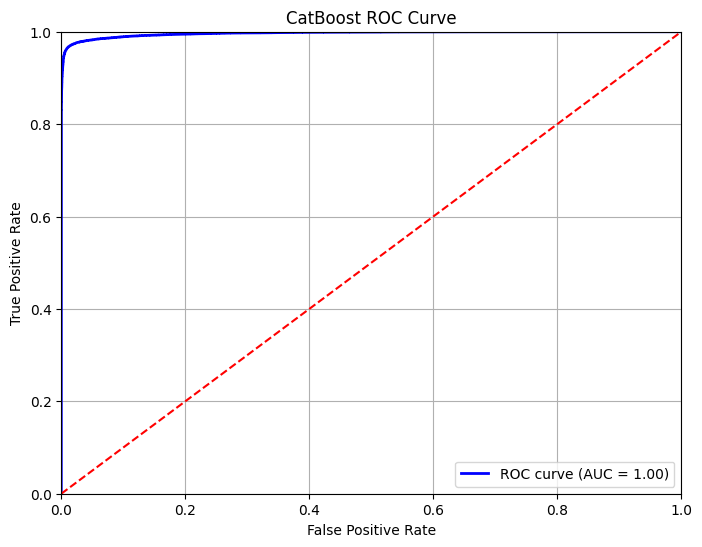

CatBoost AUC: 1.00


In [242]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc , accuracy_score

# Iterate through models, creating a pipeline for each
for name, model in models:
    # Create the pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('classifier', model)])

    # Fit the model
    pipeline.fit(x_train, y_train)

    # Check if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        # Make predictions using predict_proba
        y_pred_prob = pipeline.predict_proba(x_train)[:, 1]

        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

        # Print AUC value
        print(f'{name} AUC: {roc_auc:.2f}')

    else:
        print(f'{name} does not support predict_proba. Skipping ROC curve plotting.')
        y_pred2 = pipeline.predict(x_train)
        print(accuracy_score(y_train, y_pred2))


In [143]:
pipeline

Pipeline(steps=[('classifier', SVC())])

In [ ]:
############################################################################################################################################

# **1. Logistic Regression**

In [266]:
from sklearn.linear_model import LogisticRegression

In [267]:
logistic = LogisticRegression()
logistic.fit(x_train , y_train)

LogisticRegression()

In [268]:
y_pred = logistic.predict_proba(x_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)

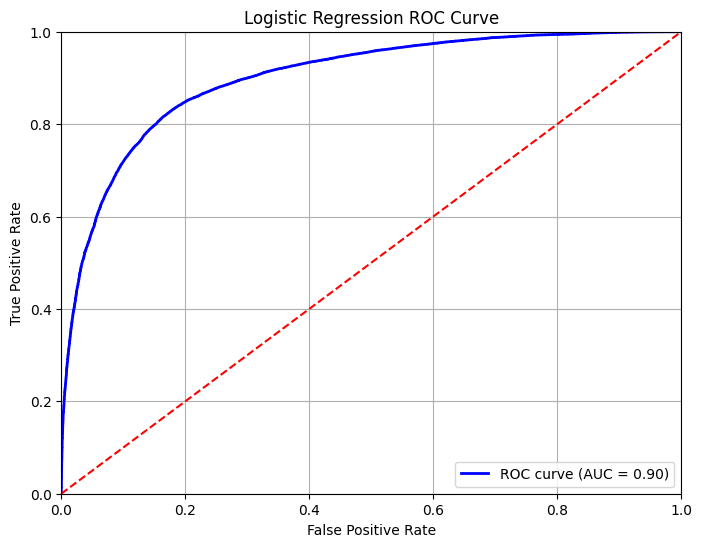

In [270]:
# Plot the ROC curve
name = 'Logistic Regression'
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{name} ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
## Submission
y_pred  = pipeline.predict(x_test)
sub = pd.read_csv('sample_submission.csv')
for i in range(len(y_pred)):
    sub.loc[i, 'loan_status'] = y_pred[i]

sub.to_csv('SV_Logistic_Submission.csv',index=False)

# **2. NAIVES BAYES**

## A --> GaussianNB

In [271]:
from sklearn.naive_bayes import GaussianNB

In [272]:
GaussianNB = GaussianNB()
GaussianNB.fit(x_train , y_train)

GaussianNB()

In [273]:
y_pred = GaussianNB.predict_proba(x_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)

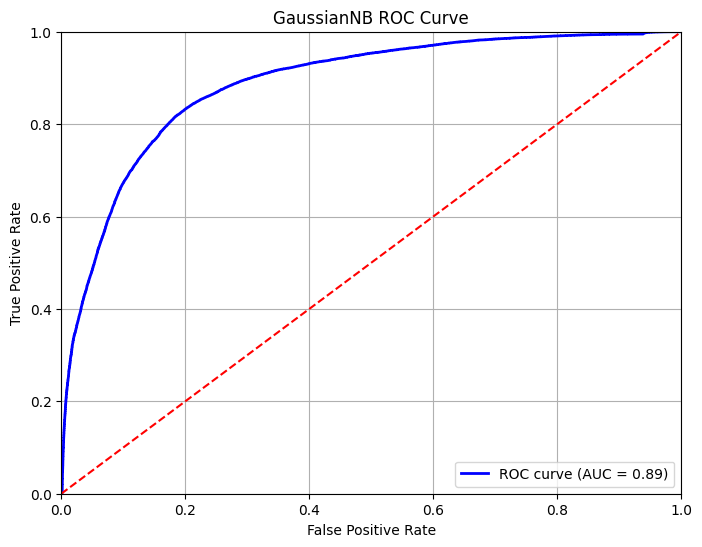

In [275]:
# Plot the ROC curve
name = 'GaussianNB'
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{name} ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## B --> MultinomialNB

# **3. DECISION TREE**

# **4. RANDOM FOREST**

# **5. SUPPORT VECTOR CLASSIFIER**

# **6. KNN**

# **7. GRADIENT BOOSTING**

# **8. XGBOOST CLASSIFIER**

# **9. LIGHTGBM CLASSIFIER**

# **10. ADABOOST CLASSIFIER**

# **11. BAGGING CLASSIFIER**

# **12. CATBOOST CLASSIFIER**

# **13. EXTRA TREE CLASSIFIER**

# **14. VOTING CLASSIFIER**

# **15. STACKING CLASSIFIER**

# **16. NEURAL NETWORK MLP CLASSIFIER**

# **17. DNN**